# Exercise 4


## Part I - creating a useful data format

Like in the previous exercise you will start creating a `pandas.DataFrame` with the necessary information

In [1]:
import ROOT
import rootpy #hands down, a better version of PyROOT
import rootpy.plotting as plt
import pprint
from DataFormats.FWLite import Events, Handle
import pandas as pd
import numpy as np
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)

Welcome to JupyROOT 6.08/07


We will need to import sevral libraries, including scikit-lean, one of the machine learning python libraries and matplotlib, one of python's plotting libraries.

In [22]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as pyplt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
import sklearn

As in the previous exercise we will have to read the input `MINIAOD` files and convert the information we want into a `pandas.DataFrame`

In [3]:
data = []
files = [
    #QCD
    '/store/relval/CMSSW_9_2_2/RelValQCD_FlatPt_15_3000HS_13/MINIAODSIM/PU25ns_92X_upgrade2017_realistic_v1-v1/10000/14008288-C84D-E711-9EFD-0025905B85BC.root',
    #'/store/relval/CMSSW_9_2_2/RelValQCD_FlatPt_15_3000HS_13/MINIAODSIM/PU25ns_92X_upgrade2017_realistic_v1-v1/10000/30858183-C84D-E711-AB11-0CC47A7C3434.root',
    #TTbar
    '/store/relval/CMSSW_9_2_2/RelValTTbar_13/MINIAODSIM/PU25ns_92X_upgrade2017_realistic_v1-v1/10000/8E7EE25F-294E-E711-A5CC-0025905B8610.root',
    #'/store/relval/CMSSW_9_2_2/RelValTTbar_13/MINIAODSIM/PU25ns_92X_upgrade2017_realistic_v1-v1/10000/44D6F368-294E-E711-958E-0025905A612C.root',
]
events = Events(['root://xrootd-cms.infn.it/%s' % i for i in files])
handle = Handle('vector<pat::Jet>')
taggers = [
    ('JP', 'pfJetProbabilityBJetTags'),
    ('JPB', 'pfJetBProbabilityBJetTags'),
    ('SoftMu', 'softPFMuonBJetTags'),
    ('SoftEl', 'softPFElectronBJetTags'),
    ('CSV_IVF', 'pfCombinedInclusiveSecondaryVertexV2BJetTags'),
    ('CSV_AVR', 'pfCombinedSecondaryVertexV2BJetTags'),
    ('CvsL', 'pfCombinedCvsLJetTags'),
    ('CvsB', 'pfCombinedCvsBJetTags'),
    ('cMVA', 'pfCombinedMVAV2BJetTags'), #FOR REFERENCE ONLY
]
for event in events:
    event.getByLabel('slimmedJets', handle)
    jets = handle.product()
    for jet in jets:
        if jet.pt() < 20 or abs(jet.eta()) > 2.4: continue #basic selection
        #A more verbose, but more consistent version with dictionaries exists
        entry = [
            jet.pt(),
            jet.eta(),
            abs(jet.hadronFlavour()), #5 - b-jet, 4 - c-jet, 0 - light
        ]
        entry.extend([jet.bDiscriminator(i) for _, i in taggers])
        data.append(entry)

Let's convert the data and look at it.

In [4]:
data = pd.DataFrame(
    data, 
    columns=(['pt', 'eta', 'flavour'] + [i for i, _ in taggers])
)
data.head()

,pt,eta,flavour,JP,JPB,SoftMu,SoftEl,CSV_IVF,CSV_AVR,CvsL,CvsB,cMVA
0,96.326202,-1.426480,0,0.033237,0.541580,-inf,-inf,0.125161,0.125161,-0.314454,0.420186,-0.965026
1,74.609001,0.186755,0,0.125105,1.398613,-inf,-inf,0.237336,0.237336,0.115812,0.462907,-0.763757
2,87.277283,2.329929,0,0.218924,0.734156,-inf,0.726604,0.777873,0.456958,0.461294,-0.138567,0.128481
3,78.739510,2.328943,0,0.061890,0.322394,-inf,-inf,0.090767,0.090767,-0.439765,0.475318,-0.982244
4,116.271942,0.412448,0,0.075692,0.386097,-inf,-inf,0.086868,0.086868,-0.271164,0.519577,-0.980381


__Always sanitize your input__

![img](img/xkcd.png)

Let's check if there are columns with `inf`s or `NaN`s. We are sure about soft electron/muons, but what about the rest?

In [5]:
for column in data.columns:
    if np.isinf(data[column]).any():
        print column, 'contains infs'
    if np.isnan(data[column]).any():
        print column, 'contains nans'

SoftMu contains infs
SoftEl contains infs


You can check yourself what are the ranged of the features with infinities, but setting them to 0 works for us

In [6]:
data.loc[np.isinf(data.SoftEl), 'SoftEl'] = 0
data.loc[np.isinf(data.SoftMu), 'SoftMu'] = 0
data.head()

We will now have to set the true labels for the training/testing of our discriminator. We will create two sets of labels:
  - __Binary labels:__ simply define if the jet is a b-jet or not
  - __multiclass labels:__ define three possible options, light, charm and b. It is the same information we have in the flavour column, but encoded differently

In [8]:
data['binary_target'] = 0
data.loc[(data.flavour == 5), 'binary_target'] = 1

data['isL'] = (data.flavour == 0)
data['isB'] = (data.flavour == 5)
data['isC'] = (data.flavour == 4)
data['clf_binary'] = 0
data['clf_multiclass'] = 0
data['clf_multiclass_C'] = 0

As in every machine learning exercise, we need to split our data into two samples, a training and a testing.

In [9]:
train, test = train_test_split(data, test_size=0.3, random_state=42)

We can now define our models. We will train two different BDTs, one trained on binary labels, one with multiclass labels.

In [24]:
features = [] #FIXME!
clf_binary = GradientBoostingClassifier(
    learning_rate=0.01, n_estimators=1000, 
    subsample=0.8, random_state=13,
    min_samples_leaf=int(0.01*len(train)),
    max_depth=5,
    verbose=1,
)
clf_multiclass = OneVsRestClassifier(sklearn.base.clone(clf_binary))

In [25]:
# Training, takes a while
clf_multiclass.fit(train[features], train[['isL', 'isC', 'isB']].as_matrix())
clf_binary.fit(train[features], train.binary_target)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=288,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=13,
              subsample=0.8, verbose=1, warm_start=False)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1852           0.0107           52.38s
         2           1.1791           0.0103           53.52s
         3           1.1622           0.0105           53.47s
         4           1.1581           0.0096           53.44s
         5           1.1498           0.0094           53.30s
         6           1.1374           0.0091           52.84s
         7           1.1219           0.0091           53.06s
         8           1.1145           0.0091           52.93s
         9           1.1124           0.0084           52.75s
        10           1.1044           0.0082           52.81s
        20           1.0326           0.0065           52.17s
        30           0.9705           0.0055           51.89s
        40           0.9215           0.0042           51.42s
        50           0.8806           0.0038           50.81s
        60           0.8457           0.0032           50.24s
       

We can now store the output of the taggers in the columns we created before. Do not mind the warning coming from the command. 

You can see that the binary classifier outputs a N time 2 matrix corresponding to $p(non-b\, |\, jet)$, $p(b\, |\, jet)$, while the multiclass has three outputs $p(light\, |\, jet)$, $p(charm\, |\, jet)$, $p(b\, |\, jet)$.

In [27]:
test['clf_binary'] = clf_binary.predict_proba(test[features])[:,1]
test['clf_multiclass'] = clf_multiclass.predict_proba(test[features])[:,2]
test['clf_multiclass_C'] = clf_multiclass.predict_proba(test[features])[:,1]

/cvmfs/cms.cern.ch/slc6_amd64_gcc530/external/py2-pippkgs/5.0-njopjo4/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/cvmfs/cms.cern.ch/slc6_amd64_gcc530/external/py2-pippkgs/5.0-njopjo4/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/cvmfs/cms.cern.ch/slc6_amd64_gcc530/external/py2-pippkgs/5.0-njopjo4/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is 

In [28]:
test.head()

,pt,eta,flavour,JP,JPB,SoftMu,SoftEl,CSV_IVF,CSV_AVR,CvsL,CvsB,cMVA,binary_target,isL,isB,isC,clf_binary,clf_multiclass,clf_multiclass_C
11242,23.694374,-0.439486,0,0.202409,0.751644,0.0,0.00000,0.369946,0.195666,-0.106124,0.586922,-0.827923,0,True,False,False,0.023040,0.023040,0.085981
26192,54.311916,-1.072498,0,0.272101,1.004778,0.0,0.00000,0.184987,0.184987,-0.220571,0.557914,-0.906575,0,True,False,False,0.015785,0.015785,0.071654
16918,31.526951,-1.003518,0,0.189412,1.272134,0.0,0.00000,0.335002,0.335002,-0.032920,0.126147,-0.751580,0,True,False,False,0.054315,0.054315,0.076504
3230,43.985874,-2.366027,0,0.151785,0.980472,0.0,0.00000,0.492127,0.492127,-0.197291,0.409359,-0.671418,0,True,False,False,0.039237,0.039237,0.062409
33511,60.725311,-0.467986,0,-0.000000,0.332886,0.0,0.03484,-10.000000,-10.000000,-2.000000,-2.000000,-0.971001,0,True,False,False,0.030134,0.030134,0.023917


We can now print the ROC curves as in the previous exercise.

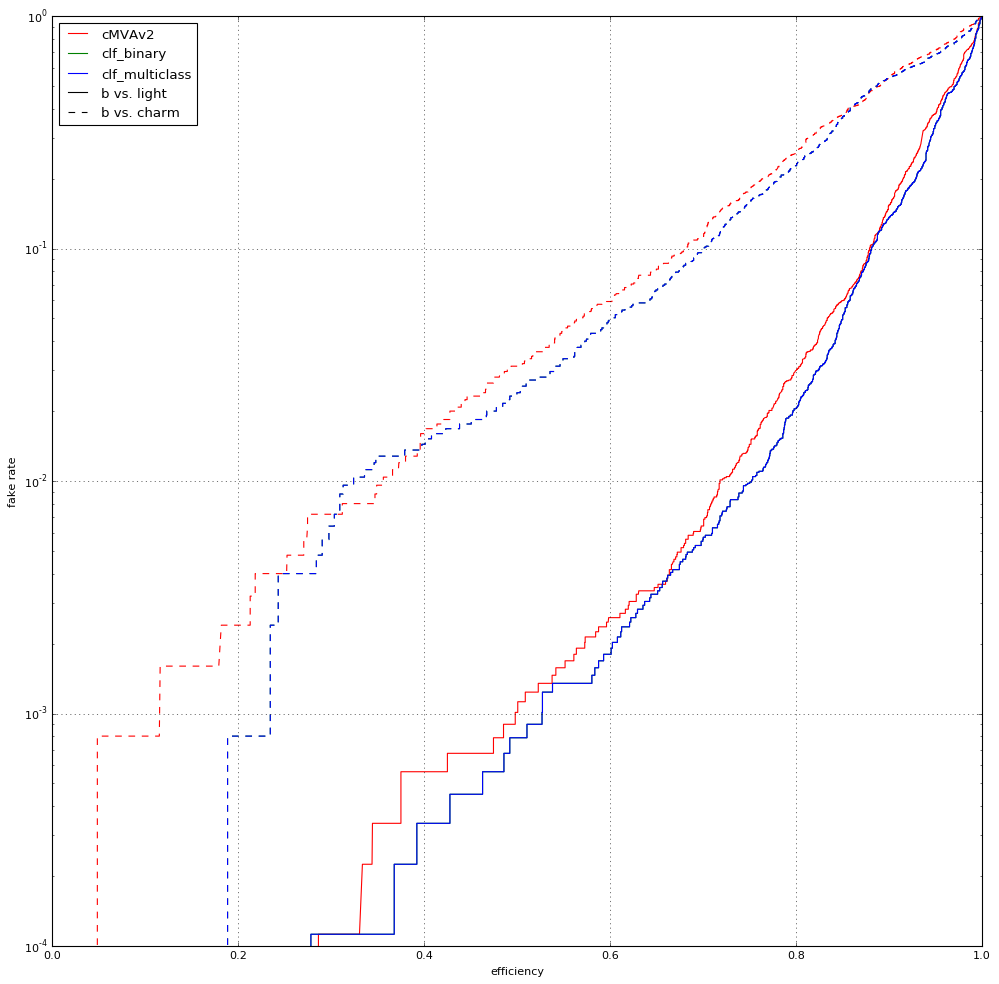

In [29]:
fig = pyplt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')
for algo, color in zip([
    'cMVA', 
    'clf_binary', 
    'clf_multiclass',
    ], 'rgb'):    
    for bkg, style in zip([4, 0], ['-', '--']):
        mask = (test.flavour != bkg)
        jets = test[mask]
        fakes_positive_rate, true_positive_rate, _ = roc_curve(jets.isB, jets[algo])
        pyplt.plot(true_positive_rate, fakes_positive_rate, '%s%s' % (color, style))

import matplotlib.lines as mlines
pyplt.legend(
    loc='best',
    handles=[
        mlines.Line2D([],[], color='red', ls='-', label='cMVAv2'),
        mlines.Line2D([],[], color='green', ls='-', label='clf_binary'),
        mlines.Line2D([],[], color='blue', ls='-', label='clf_multiclass'),
        mlines.Line2D([],[], color='k', ls='-', label='b vs. light'),
        mlines.Line2D([],[], color='k', ls='--', label='b vs. charm'),        
        ])
        
pyplt.xlabel('efficiency')
pyplt.ylabel('fake rate')
pyplt.grid(True)
pyplt.yscale('log', nonposy='clip')
pyplt.show()

Can you make the charm-vs-light and charm-vs-b plots for the discriminators considered?